#### Components of time series

series = trend + seasons + error

Residuals - difference between the target the model was trained on and the predictions the model makes (the difference between the actual curve and the fitted curve)

Method of fitting to residuals - boosted hybrids

Method of using predictions as features - stacked hybrids

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [3]:
# Load data
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv("../datasets/us-retail-sales.csv", 
                     usecols=["Month"] + industries, 
                     parse_dates=["Month"], 
                     index_col="Month").to_period("D").reindex(columns=industries)
retail = pd.concat({"Sales": retail}, names=[None, "Industries"], axis=1)

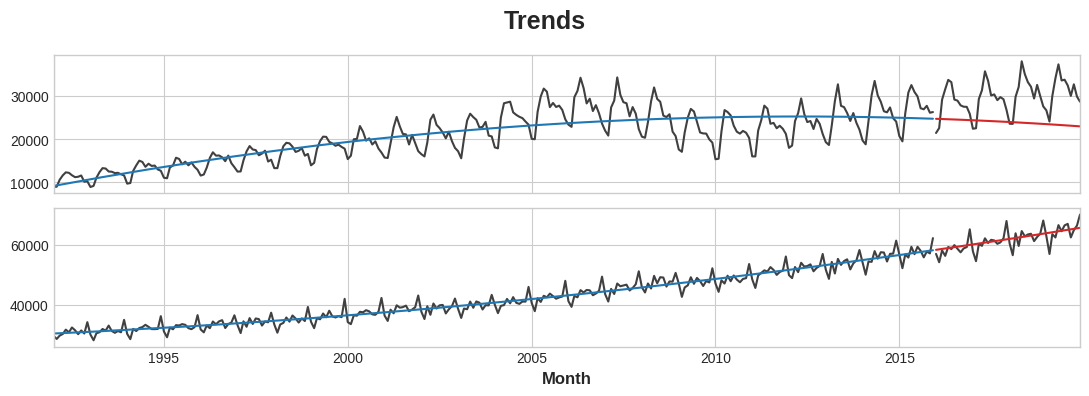

In [4]:
# Linear regression - quadratic(order 2) trend
y = retail.copy()

# Trend features
dp = DeterministicProcess(index=y.index,constant=True,order=2, drop=True,)
X = dp.in_sample() # features for the training data

# Test for years 2016 - 2019
idx_train, idx_test = train_test_split(y.index, test_size=12 * 4, shuffle=False,)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns,)
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=y_test.columns,)

# Plot
axs = y_train.plot(color="0.25", subplots=True, sharex=True)
axs = y_test.plot(color="0.25", subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color="C0", subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color="C3", subplots=True, sharex=True, ax=axs)
for ax in axs:
    ax.legend([])
_ = plt.suptitle("Trends")


In [5]:
# Stack column labes to row labels
X = retail.stack()
display(X.head())
y = X.pop("Sales")


Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [6]:
X.head()

Empty DataFrame
Columns: []
Index: [(1992-01-01, BuildingMaterials), (1992-01-01, FoodAndBeverage), (1992-02-01, BuildingMaterials), (1992-02-01, FoodAndBeverage), (1992-03-01, BuildingMaterials)]

In [7]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index("Industries")
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [8]:
# Pivot wide to long
y_fit = y_fit.stack().squeeze() # trend from train set
y_pred = y_pred.stack().squeeze() # trend from test set

# Create residuals
y_resid = y_train - y_fit

# Train XGBoost on resoduals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

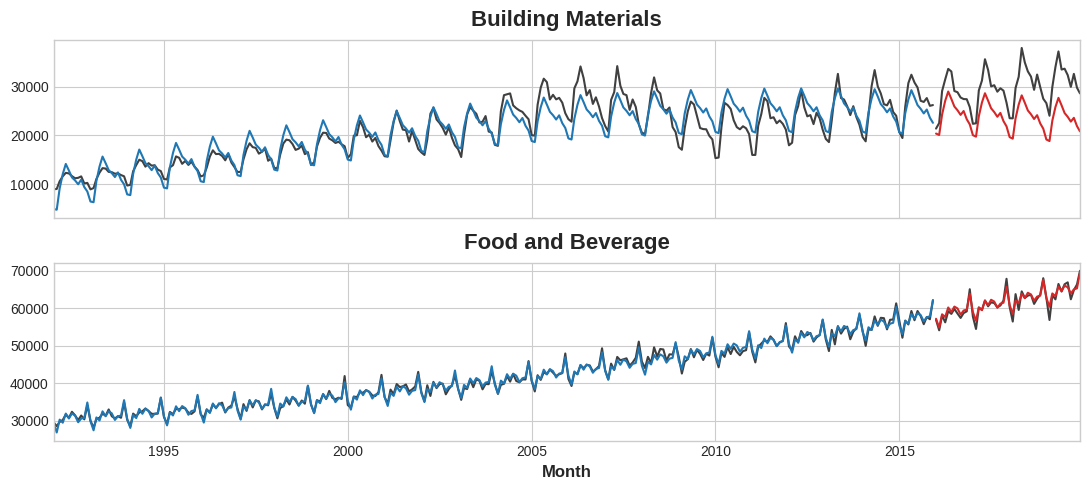

In [9]:
# Plot
axs = y_train.unstack(["Industries"]).plot(
    color="0.25", figsize=(11, 5), subplots=True, sharex=True, title=["Building Materials", "Food and Beverage"],
)
axs = y_test.unstack(["Industries"]).plot(
    color="0.25", subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(["Industries"]).plot(
    color="C0", subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(["Industries"]).plot(
    color="C3", subplots=True, sharex=True, ax=axs,
)
for ax in axs:
    ax.legend([])